In [1]:
!pip install pretrainedmodels
!pip install utils
!pip install "torch==1.4" "torchvision==0.5.0"

     |████████████████████████████████| 61kB 3.9MB/s 
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-cp36-none-any.whl size=60963 sha256=bbd76a602cdab21735d5c3bcc92683aed66d9dcbe62336eb173da3e9c690187f
  Stored in directory: /root/.cache/pip/wheels/69/df/63/62583c096289713f22db605aa2334de5b591d59861a02c2ecd
Successfully built pretrainedmodels
     |████████████████████████████████| 753.4MB 22kB/s 
     |████████████████████████████████| 4.0MB 48.4MB/s 
  Found existing installation: torch 1.7.0+cu101
    Uninstalling torch-1.7.0+cu101:
      Successfully uninstalled torch-1.7.0+cu101
  Found existing installation: torchvision 0.8.1+cu101
    Uninstalling torchvision-0.8.1+cu101:
      Successfully uninstalled torchvision-0.8.1+cu101


In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import numpy as np
from fastai.vision import *
from fastai.metrics import error_rate
import random

In [4]:
from torchvision.models import *
import pretrainedmodels

from fastai.vision.models import *
from fastai.vision.learner import model_meta

from utils import *
import sys
import torch

In [5]:
bs = 16

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:

path = '/content/drive/My Drive/images_corrected_no_classes/'
img_folder = 'images/'

measles_img = get_image_files(path + img_folder + "Measles")
not_measles_img = get_image_files(path + img_folder + "Not_Measles")

print(len(measles_img), len(not_measles_img))

158 1158


# **Cross validation**

In [ ]:
random.shuffle(measles_img)
random.shuffle(not_measles_img)

cut_point_m = [int(len(measles_img)* n/5) for n in range(1,5)]
cut_point_n = [int(len(not_measles_img)* n/5) for n in range(1,5)]

print(cut_point_m)
print(cut_point_n)

[31, 63, 94, 126]
[231, 463, 694, 926]


In [ ]:
%cd $path
!mkdir -p valid/Measles valid/Not_Measles train/Measles train/Not_Measles

/content/drive/My Drive/images_corrected_no_classes


In [ ]:
def create_img_symlinks(fnames, folder, rm_file=True):
  %cd $folder 
  if rm_file:
    %rm -f *
  for f in fnames:
    !cp "$f" .

In [ ]:
def prepare_img_files(idx_min_m, idx_max_m, idx_min_n, idx_max_n):
    # Create symlinks for images in validation set
    create_img_symlinks(    measles_img[idx_min_m:idx_max_m], path+"valid/Measles")
    create_img_symlinks(not_measles_img[idx_min_n:idx_max_n], path+"valid/Not_Measles")    
    # Create symlinks for images in training set
    if idx_min_m>0:
        create_img_symlinks(measles_img[:idx_min_m],      path+"train/Measles")
    if idx_max_m<len(measles_img):
        create_img_symlinks(measles_img[idx_max_m:],      path+"train/Measles", idx_min_m==0)
    if idx_min_n>0:
        create_img_symlinks(not_measles_img[:idx_min_n],  path+"train/Not_Measles")
    if idx_max_n<len(not_measles_img):
        create_img_symlinks(not_measles_img[idx_max_n:],  path+"train/Not_Measles", idx_min_n==0)

In [ ]:
def model_training(mdl_idx):
    data = ImageDataBunch.from_folder(path= path, train='train', valid='valid', bs=bs, ds_tfms=get_transforms(), 
                                  size=299, num_workers=0).normalize(imagenet_stats)
    learn = cnn_learner(data, models.mobilenet_v2, metrics={error_rate,accuracy})
    #
    learn.fit_one_cycle(8)
    #
    mdl_name = 'stage-3-50-'+str(mdl_idx)
    learn.save(mdl_name)
    #
    interp = ClassificationInterpretation.from_learner(learn)
    #
    interp.most_confused(min_val=2)
    #
    interp.plot_confusion_matrix(figsize=(6,6),dpi=60)
    #
    learn.unfreeze()
    #
    learn.lr_find()
    learn.recorder.plot()
    #
    learn.fit_one_cycle(1, max_lr=slice(1e-6,1e-4))
    #
    # learn.load(mdl_name);
    #
    interp = ClassificationInterpretation.from_learner(learn)
    #
    interp.most_confused(min_val=2)
    #
    interp.plot_confusion_matrix(figsize=(6,6),dpi=60)
    #
    #create a file named 'export.pkl' in the directory where we were working that contains everything we need to deploy our model (the model, the weights but also some metadata like the classes or the transforms/normalization used)
    learn.export()
    #saved in the training images file
    #
    from_file = path + "/export.pkl"
    to_file = path + "/models/export-" + str(mdl_idx) + ".pkl"
    %mv $from_file $to_file

# **First iteration of cross validation**

/content/drive/My Drive/images_corrected_no_classes/valid/Measles
/content/drive/My Drive/images_corrected_no_classes/valid/Not_Measles
/content/drive/My Drive/images_corrected_no_classes/train/Measles
/content/drive/My Drive/images_corrected_no_classes/train/Not_Measles


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.997083,0.639917,0.732824,0.267176,01:11
1,0.683697,0.544026,0.805344,0.194656,01:10
2,0.407841,0.275198,0.908397,0.091603,01:11
3,0.316671,0.169152,0.935115,0.064885,01:10
4,0.242912,0.260370,0.900763,0.099237,01:11
5,0.182405,0.175741,0.946565,0.053435,01:12
6,0.150475,0.169649,0.958015,0.041985,01:13
7,0.121509,0.158602,0.954198,0.045802,01:12


epoch,train_loss,valid_loss,accuracy,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.114942,0.157874,0.954198,0.045802,01:14


mv: target 'Drive/images_corrected_no_classes//models/export-1.pkl' is not a directory


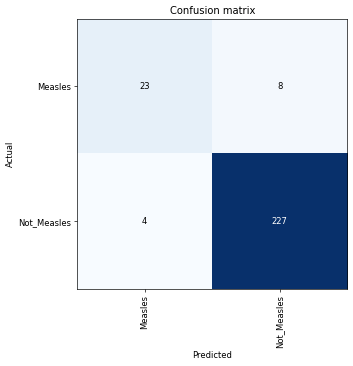

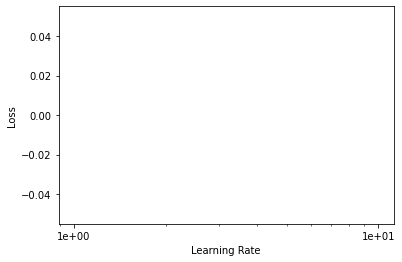

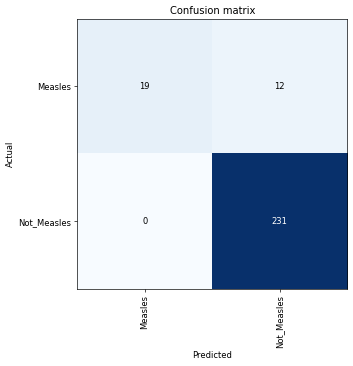

In [ ]:
prepare_img_files(0, cut_point_m[0], 0, cut_point_n[0])

#np.random.seed(42)
model_training(1)

# **`Second iteration of cross validation`**

/content/drive/My Drive/images_corrected_no_classes/valid/Measles
/content/drive/My Drive/images_corrected_no_classes/valid/Not_Measles
/content/drive/My Drive/images_corrected_no_classes/train/Measles
/content/drive/My Drive/images_corrected_no_classes/train/Measles
/content/drive/My Drive/images_corrected_no_classes/train/Not_Measles
/content/drive/My Drive/images_corrected_no_classes/train/Not_Measles


Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/checkpoints/mobilenet_v2-b0353104.pth


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.043552,0.688032,0.731061,0.268939,01:15
1,0.658869,0.383844,0.859848,0.140152,01:11
2,0.433123,0.368021,0.882576,0.117424,01:10
3,0.270243,0.220430,0.920455,0.079545,01:10
4,0.215347,0.216701,0.935606,0.064394,01:10
5,0.185657,0.208291,0.928030,0.071970,01:10
6,0.176803,0.180153,0.943182,0.056818,01:10
7,0.151152,0.180991,0.943182,0.056818,01:10


epoch,train_loss,valid_loss,accuracy,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.109124,0.187434,0.943182,0.056818,01:11


mv: target 'Drive/images_corrected_no_classes//models/export-2.pkl' is not a directory


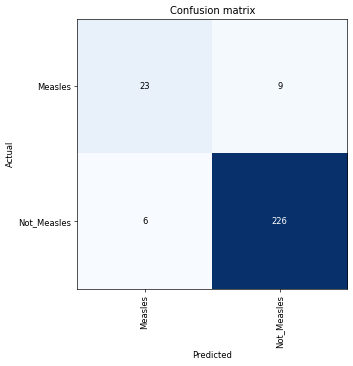

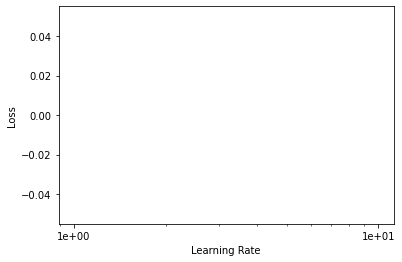

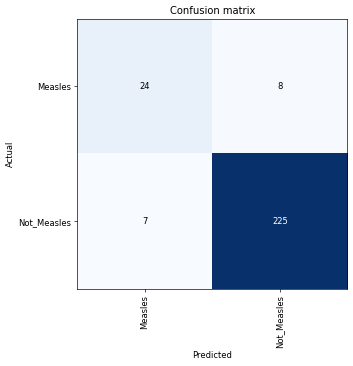

In [ ]:
prepare_img_files(cut_point_m[0], cut_point_m[1], cut_point_n[0], cut_point_n[1])

model_training(2)

# **Third iteration of cross validation**

/content/drive/My Drive/images_corrected_no_classes/valid/Measles
/content/drive/My Drive/images_corrected_no_classes/valid/Not_Measles
/content/drive/My Drive/images_corrected_no_classes/train/Measles
/content/drive/My Drive/images_corrected_no_classes/train/Measles
/content/drive/My Drive/images_corrected_no_classes/train/Not_Measles
/content/drive/My Drive/images_corrected_no_classes/train/Not_Measles


Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/checkpoints/mobilenet_v2-b0353104.pth


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.007456,0.631460,0.698473,0.301527,01:15
1,0.702548,0.311488,0.870229,0.129771,01:12
2,0.433827,0.265225,0.908397,0.091603,01:14
3,0.317137,0.194945,0.919847,0.080153,01:10
4,0.244695,0.203506,0.923664,0.076336,01:09
5,0.177587,0.121409,0.938931,0.061069,01:11
6,0.142736,0.130942,0.938931,0.061069,01:10
7,0.132413,0.108542,0.946565,0.053435,01:10


epoch,train_loss,valid_loss,accuracy,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.126184,0.136948,0.942748,0.057252,01:12


mv: target 'Drive/images_corrected_no_classes//models/export-3.pkl' is not a directory


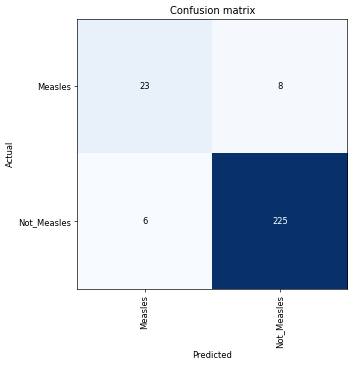

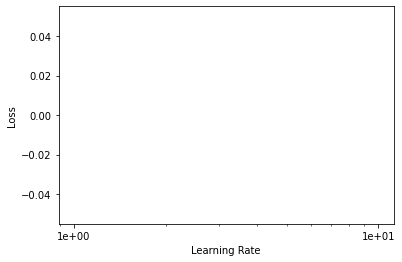

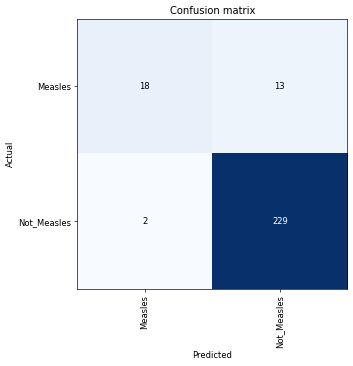

In [ ]:
prepare_img_files(cut_point_m[1], cut_point_m[2], cut_point_n[1], cut_point_n[2])

model_training(3)

# **Fourth iteration of cross validation**

/content/drive/My Drive/images_corrected_no_classes/valid/Measles
/content/drive/My Drive/images_corrected_no_classes/valid/Not_Measles
/content/drive/My Drive/images_corrected_no_classes/train/Measles
/content/drive/My Drive/images_corrected_no_classes/train/Measles
/content/drive/My Drive/images_corrected_no_classes/train/Not_Measles
/content/drive/My Drive/images_corrected_no_classes/train/Not_Measles


Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/checkpoints/mobilenet_v2-b0353104.pth


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.078646,0.860953,0.681818,0.318182,01:13
1,0.760157,0.386807,0.856061,0.143939,01:12
2,0.432285,0.217288,0.916667,0.083333,01:13
3,0.282662,0.209865,0.935606,0.064394,01:12
4,0.209417,0.168707,0.924242,0.075758,01:12
5,0.151025,0.189313,0.939394,0.060606,01:13
6,0.132165,0.178526,0.954545,0.045455,01:12
7,0.110987,0.176954,0.950758,0.049242,01:12


epoch,train_loss,valid_loss,accuracy,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.111553,0.194118,0.946970,0.053030,01:13


mv: target 'Drive/images_corrected_no_classes//models/export-4.pkl' is not a directory


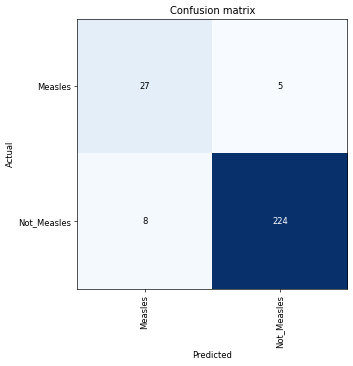

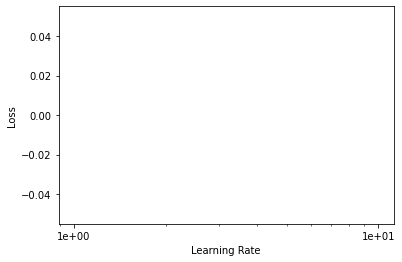

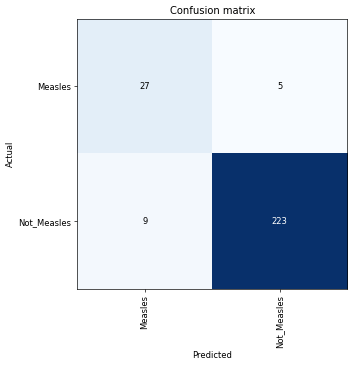

In [ ]:
prepare_img_files(cut_point_m[2], cut_point_m[3], cut_point_n[2], cut_point_n[3])

model_training(4)

# **Fifth iteration of cross validation**

/content/drive/My Drive/images_corrected_no_classes/valid/Measles
/content/drive/My Drive/images_corrected_no_classes/valid/Not_Measles
/content/drive/My Drive/images_corrected_no_classes/train/Measles
/content/drive/My Drive/images_corrected_no_classes/train/Not_Measles


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.065845,0.659716,0.750000,0.250000,01:11
1,0.692279,0.474386,0.840909,0.159091,01:11
2,0.405563,0.185230,0.935606,0.064394,01:11
3,0.269127,0.203304,0.924242,0.075758,01:11
4,0.235367,0.146203,0.931818,0.068182,01:10
5,0.183150,0.165669,0.924242,0.075758,01:11
6,0.140377,0.131770,0.954545,0.045455,01:10
7,0.116166,0.127228,0.946970,0.053030,01:11


epoch,train_loss,valid_loss,accuracy,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.116139,0.120815,0.958333,0.041667,01:12


mv: target 'Drive/images_corrected_no_classes//models/export-5.pkl' is not a directory


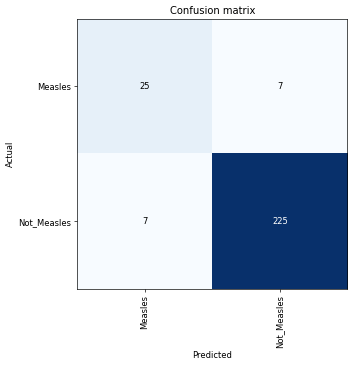

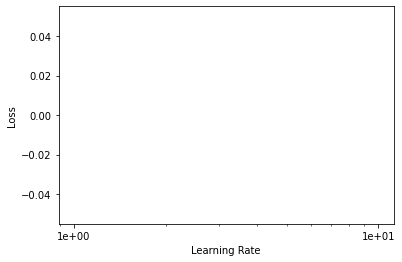

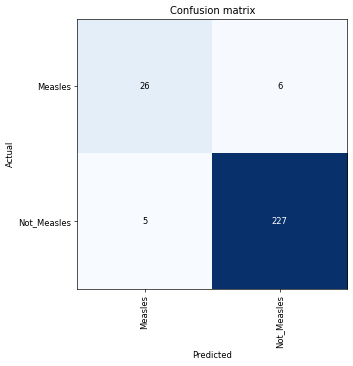

In [ ]:
prepare_img_files(cut_point_m[3], len(measles_img), cut_point_n[3], len(not_measles_img))

model_training(5)